In [16]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [17]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
from dateutil.parser import parse 
from pyspark.sql.types import *
from pyspark.sql.functions import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

In [8]:
hadoopUrl = 'hdfs://hadoop-vm.internal.cloudapp.net:9000'
station = 235
data_files = f'{hadoopUrl}/precipitation/data/{station}/*.parquet'

# Obtain dataset
df = spark.read.parquet(data_files) \
        .withColumn("precipitation", col("precipitation").cast("float")) \
        .select("date","precipitation") \
        .toPandas()

In [9]:
# Set the date column as the index and ensure it's a DatetimeIndex
df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df.head()

,precipitation
date,
1927-07-01,0.0
1927-07-02,1.9
1927-07-03,0.1
1927-07-04,0.0
1927-07-05,0.0


# Stationary Test

In [10]:
#%pip install arch

In [11]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron

def test_stationarity(time_series):
    # Perform ADF test
    adf_result = adfuller(time_series, autolag='AIC')
    print("ADF Test:")
    print("=========")
    print(f"Test statistic: {adf_result[0]}")
    print(f"null_hypothesis: the time series is non-stationary")
    p_value = adf_result[1]
    print(f"P-value: {p_value}")
    print("Critical values:")
    for key, value in adf_result[4].items():
        print(f"{key}: {value}")
    
    result = "STATIONARY" if p_value < 0.05 else "NON-STATIONARY"
    print(result)
    

    print("\nKPSS Test:")
    print("============")
    kpss_result = kpss(time_series, regression='ct')  # 'ct' for constant and trend
    print(f"null_hypothesis: the time series is trend stationary")
    print(f"Test statistic: {kpss_result[0]}")
    print(f"P-value: {kpss_result[1]}")
    p_value = kpss_result[1]
    print("Critical values:")
    for key, value in kpss_result[3].items():
        print(f"{key}: {value}")
        
    result = "NON-STATIONARY" if p_value < 0.05 else "STATIONARY"
    print(result)


In [12]:
#Montly
test_stationarity(df.precipitation)

ADF Test:
Test statistic: -24.08518332860355
null_hypothesis: the time series is non-stationary
P-value: 0.0
Critical values:
1%: -3.430537337961998
5%: -2.861622798743007
10%: -2.5668140711697944
STATIONARY

KPSS Test:
null_hypothesis: the time series is trend stationary
Test statistic: 0.039872187751858884
P-value: 0.1
Critical values:
10%: 0.119
5%: 0.146
2.5%: 0.176
1%: 0.216
STATIONARY


/anaconda/envs/py38_default/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


# SARIMA

In [13]:
def remove_outlier(df):
    # Calculate the IQR
    Q1 = df['precipitation'].quantile(0.25)
    Q3 = df['precipitation'].quantile(0.75)
    IQR = Q3 - Q1

    # Define the bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out the outliers
    output = df[(df['precipitation'] >= lower_bound) & (df['precipitation'] <= upper_bound)]
    print(f"Records removed: {df.shape[0] - output.shape[0]}")
    return output


In [14]:
# remove outliers
df_seasson = remove_outlier(df).resample('1M').mean()
df_seasson.shape

Records removed: 4089


(1149, 1)

## Stationary test

In [16]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron

def test_stationarity(time_series):
    # Perform ADF test
    adf_result = adfuller(time_series, autolag='AIC')
    print("ADF Test:")
    print("=========")
    print(f"Test statistic: {adf_result[0]}")
    print(f"null_hypothesis: the time series is non-stationary")
    p_value = adf_result[1]
    print(f"P-value: {p_value}")
    print("Critical values:")
    for key, value in adf_result[4].items():
        print(f"{key}: {value}")
    
    result = "STATIONARY" if p_value < 0.05 else "NON-STATIONARY"
    print(result)
    

    print("\nKPSS Test:")
    print("============")
    kpss_result = kpss(time_series, regression='ct')  # 'ct' for constant and trend
    print(f"null_hypothesis: the time series is trend stationary")
    print(f"Test statistic: {kpss_result[0]}")
    print(f"P-value: {kpss_result[1]}")
    p_value = kpss_result[1]
    print("Critical values:")
    for key, value in kpss_result[3].items():
        print(f"{key}: {value}")
        
    result = "NON-STATIONARY" if p_value < 0.05 else "STATIONARY"
    print(result)

#Montly
test_stationarity(df_seasson.precipitation)

ADF Test:
Test statistic: -6.861603144139749
null_hypothesis: the time series is non-stationary
P-value: 1.5972583727919167e-09
Critical values:
1%: -3.4361760299117914
5%: -2.8641125290596436
10%: -2.5681396861234567
STATIONARY

KPSS Test:
null_hypothesis: the time series is trend stationary
Test statistic: 0.02409270760452433
P-value: 0.1
Critical values:
10%: 0.119
5%: 0.146
2.5%: 0.176
1%: 0.216
STATIONARY


/anaconda/envs/py38_default/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


## SARIMA

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

df_seasson = df.resample('1M').mean()
train_data = df_seasson.iloc[:-160]  # Adjust the number of months for testing as needed
test_data = df_seasson.iloc[-160:]


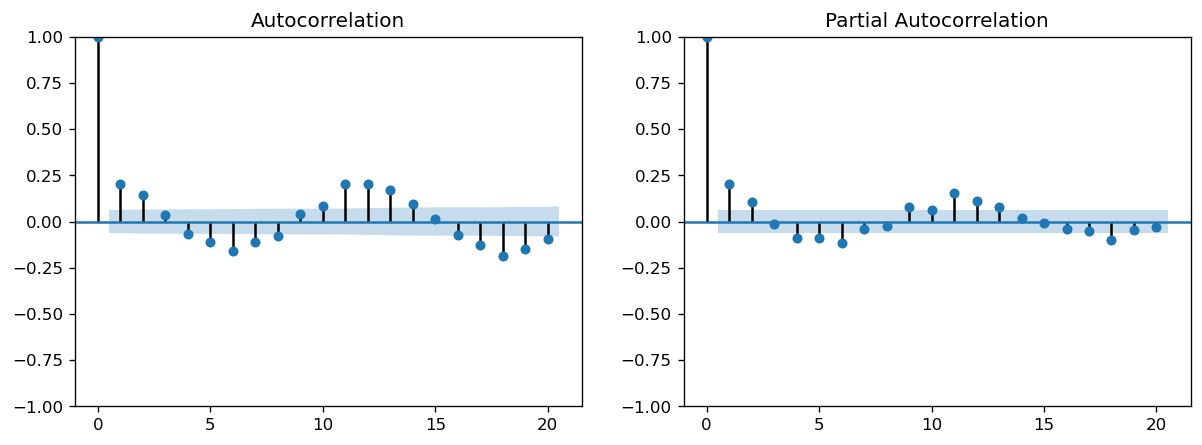

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(train_data, lags=20, ax=ax1)
plot_pacf(train_data, lags=20, ax=ax2)
plt.show()


In [30]:
p = 1
d = 0
q = 1
s = 12  # Seasonal period (e.g., 12 for monthly data with yearly seasonality)
P = 1
D = 1
Q = 1

model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.72537D+00    |proj g|=  2.44120D-01


 This problem is unconstrained.



At iterate    5    f=  1.62887D+00    |proj g|=  6.87529D-02

At iterate   10    f=  1.61994D+00    |proj g|=  1.00963D-02

At iterate   15    f=  1.61892D+00    |proj g|=  2.59202D-02

At iterate   20    f=  1.61788D+00    |proj g|=  5.37802D-03

At iterate   25    f=  1.61784D+00    |proj g|=  1.35393D-04

At iterate   30    f=  1.61783D+00    |proj g|=  3.47112D-03

At iterate   35    f=  1.61734D+00    |proj g|=  1.05486D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     53      1     0     0   1.148D-06   1.617D+00
  F =   1.6173398413955160     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

In [33]:
predictions = results.get_forecast(steps=len(test_data))
mean_predictions = predictions.predicted_mean

rmse = np.sqrt(mean_squared_error(test_data, mean_predictions))
print(f"RMSE: {rmse}")


RMSE: 1.4802511062129287


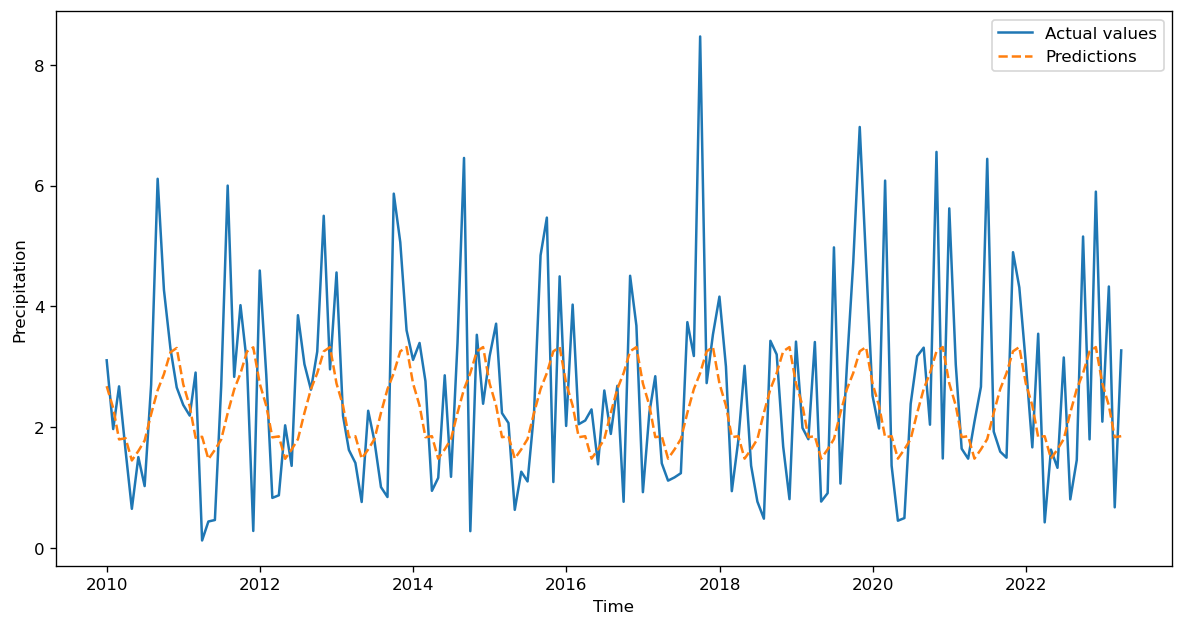

In [34]:
plt.figure(figsize=(12, 6))
#plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Actual values')
plt.plot(mean_predictions, label='Predictions', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Precipitation')
plt.legend()
plt.show()


## AUTO ARIMA

In [22]:
#%pip install pmdarima

In [40]:
import pmdarima as pm

df_seasson = df.resample('1M').mean()

train_data = df_seasson.iloc[:-int(df_seasson.shape[0]*0.2)]  # Adjust the number of months for testing as needed
test_data = df_seasson.iloc[-int(df_seasson.shape[0]*0.2):]


auto_model = pm.auto_arima(train_data,
                      seasonal=True,
                      m=12,  # Seasonal frequency
                      start_p=0, start_q=0, max_p=3, max_q=3,  # Non-seasonal parameters
                      start_P=0, start_Q=0, max_P=3, max_Q=3,  # Seasonal parameters
                      d=None, D=None,  # Orders of differencing
                      trace=True,  # Print search information
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)  # Stepwise search for efficiency



Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3532.086, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3327.171, Time=0.26 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=2.46 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3530.087, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3336.469, Time=0.06 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=3328.875, Time=0.65 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.94 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3327.506, Time=0.28 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=5.38 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=3532.027, Time=0.17 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=3268.222, Time=0.34 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=3285.837, Time=0.10 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=3267.085, Time=0.92 sec
 ARIMA(2,1,0)(3,0,0)[12] intercept   : AIC=3255.708, Time=1.83 sec
 ARIMA(2,1,0)(3,0,1)[12] intercept

In [44]:
print(f"Best SARIMA Model: {auto_model.order}, {auto_model.seasonal_order}")

Best SARIMA Model: (3, 1, 0), (3, 0, 0, 12)


In [45]:
model = SARIMAX(train_data, order=auto_model.order, seasonal_order=auto_model.seasonal_order)
results = model.fit()


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.76303D+00    |proj g|=  1.05353D-01

At iterate    5    f=  1.74676D+00    |proj g|=  4.78179D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      6      8      1     0     0   6.039D-06   1.747D+00
  F =   1.7467646762406115     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [46]:
predictions = results.get_forecast(steps=len(test_data))
mean_predictions = predictions.predicted_mean

rmse = np.sqrt(mean_squared_error(test_data, mean_predictions))
print(f"RMSE: {rmse}")


RMSE: 2.000983506078686


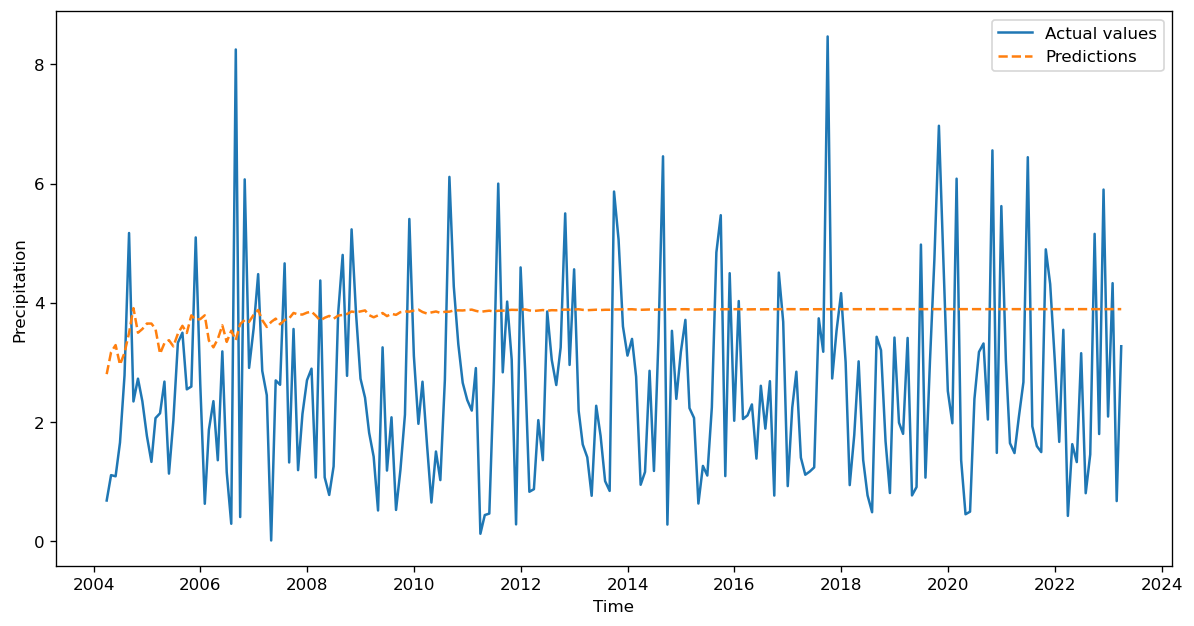

In [47]:
plt.figure(figsize=(12, 6))
#plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Actual values')
plt.plot(mean_predictions, label='Predictions', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Precipitation')
plt.legend()
plt.show()